<a href="https://colab.research.google.com/github/miketech-traces/fynesse_mlfc/blob/main/Maize_Productivity_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kenyan Agricultural Productivity Forecasting at the County Level Using emographic and Environmental Information
*Author: Mike Gikundi*  

This notebook predicts **maize yield per hectare** across Kenyan counties using historical production, land, and population data.
The data used in this project were obtained from trusted national sources. County-level maize production data for the years 2012–2020 were sourced from the Kenya National Bureau of Statistics (KNBS) / National Information Platform for Food and Nutrition (NIPFN) :https://nipfn.knbs.or.ke/download/maize-production-by-county-2012-2020/
. Population and demographic data were drawn from the 2019 Kenya Population and Housing Census, also published by KNBS https://www.knbs.or.ke/census/
. These datasets were combined and enriched with derived indicators such as yield per capita, population density, and log-transformed variables to improve model performance and interpretability.  

**Objectives:**
- Clean and preprocess maize production and population datasets.  
- Engineer features such as per-capita, log-transformed, and anomaly-based targets.  
- Train predictive models and evaluate their performance.  
- Visualize trends and provide insights for agriculture planning.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib
import statsmodels.api as sm
import seaborn as sns

In [3]:
%%capture
%pip install osmnx

In [41]:

import sys, os

!rm -rf fynesse_mlfc
!git clone https://github.com/miketech-traces/fynesse_mlfc.git

repo_path = os.path.abspath("fynesse_mlfc")
if repo_path not in sys.path:
    sys.path.append(repo_path)

from fynesse.access import load_maize_data, load_population_data, load_agricultural_production

print("✅ Repo reloaded and functions ready to use")


Cloning into 'fynesse_mlfc'...
remote: Enumerating objects: 390, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 390 (delta 43), reused 21 (delta 21), pack-reused 332 (from 3)
Receiving objects: 100% (390/390), 7.73 MiB | 23.48 MiB/s, done.
Resolving deltas: 100% (202/202), done.
✅ Repo reloaded and functions ready to use


## 1. Data Access
We start by loading maize production and population datasets.


In [7]:
maize_df = pd.read_excel('Maize-Production-2012-2020-Combined.xlsx')
population_df = pd.read_csv('2019-population_census-report-per-county.csv')
agricultural_production_df = pd.read_excel('Kenyas_Agricultural_Production.xlsx')

In [ ]:
maize_df.head()

Unnamed: 0           Unnamed: 1       Unnamed: 2     Unnamed: 3  \
0        NaN                 2012              NaN            NaN   
1     COUNTY  Harvested Area (HA)  Production (MT)  Yield (MT/HA)   
2    Baringo                39753         71866.62       1.807829   
3      Bomet                32697         73277.82       2.241118   
4    Bungoma                96209        262381.05       2.727199   

            Unnamed: 4       Unnamed: 5     Unnamed: 6           Unnamed: 7  \
0                 2013              NaN            NaN                 2014   
1  Harvested Area (HA)  Production (MT)  Yield (MT/HA)  Harvested Area (HA)   
2                29117         55805.04       1.916579                34960   
3                30620          72235.8       2.359105                30940   
4                92705        221586.03       2.390227                98074   

        Unnamed: 8     Unnamed: 9  ...    Unnamed: 15       Unnamed: 16  \
0              NaN            NaN  ...            NaN              2017   
1  Production (MT)  Yield (MT/HA)  ...  Yield (MT/HA)   Area (HA)  2017   
2            34959       0.999971  ...       2.186021             33308   
3            53162       1.718229  ...       1.410287             33792   
4           267302       2.725513  ...       2.989396             95323   

              Unnamed: 17   Unnamed: 18   Unnamed: 19        Unnamed: 20  \
0                     NaN           NaN          2018                NaN   
1   Production (MT)  2017  Yield(MT/HA)  Area Ha 2018  Quantity Ton 2018   
2                   45764      1.373964         37658            58475.6   
3                   56601      1.674982         33291           58336.81   
4                  289290      3.034839         93484           295481.1   

    Unnamed: 21     Unnamed: 22           Unnamed: 23    Unnamed: 24  
0           NaN            2020                   NaN            NaN  
1  Yield(MT/HA)  Area (Ha) 2020  Production (MT) 2020  Yield (MT/HA)  
2      1.552807           47437              68374.39       1.441373  
3       1.75233           38163              73609.65       1.928822  
4      3.160767           87960             317912.33       3.614283  

[5 rows x 25 columns]

In [ ]:
population_df.head()

County Total_Population19 Male populatio 2019  \
0          Baringo           666,763             336,322    
1            Bomet           875,689             434,287    
2          Bungoma         1,670,570             812,146    
3            Busia           893,681             426,252    
4  Elgeyo-Marakwet           454,480             227,317    

  Female population 2019 Households  Av_HH_Size  LandArea Population Density  \
0               330,428    142,518            5   10,976                 61    
1               441,379    187,641            5    2,531                346    
2               858,389    358,796            5    3,024                552    
3               467,401    198,152            5    1,696                527    
4               227,151     99,861            5    3,032                150    

  Population in 2009 Pop_change  Intersex population 2019  
0           555,561    111,202                         13  
1           724,186    151,503                         23  
2         1,630,934     39,636                         35  
3           488,075    405,606                         28  
4           369,998     84,482                         12

In [ ]:
population_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   County                    47 non-null     object
 1   Total_Population19        47 non-null     object
 2   Male populatio 2019       47 non-null     object
 3   Female population 2019    47 non-null     object
 4   Households                47 non-null     object
 5   Av_HH_Size                47 non-null     int64 
 6   LandArea                  47 non-null     object
 7   Population Density        47 non-null     object
 8   Population in 2009        47 non-null     object
 9   Pop_change                47 non-null     object
 10  Intersex population 2019  47 non-null     int64 
dtypes: int64(2), object(9)
memory usage: 4.2+ KB


In [ ]:
population_df.describe()

Av_HH_Size  Intersex population 2019
count   47.000000                 47.000000
mean     4.340426                 32.425532
std      0.938931                 38.490961
min      3.000000                  2.000000
25%      4.000000                 18.000000
50%      4.000000                 25.000000
75%      5.000000                 34.000000
max      7.000000                245.000000

In [ ]:
maize_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   48 non-null     object
 1   Unnamed: 1   49 non-null     object
 2   Unnamed: 2   48 non-null     object
 3   Unnamed: 3   48 non-null     object
 4   Unnamed: 4   49 non-null     object
 5   Unnamed: 5   48 non-null     object
 6   Unnamed: 6   48 non-null     object
 7   Unnamed: 7   49 non-null     object
 8   Unnamed: 8   48 non-null     object
 9   Unnamed: 9   48 non-null     object
 10  Unnamed: 10  49 non-null     object
 11  Unnamed: 11  48 non-null     object
 12  Unnamed: 12  48 non-null     object
 13  Unnamed: 13  49 non-null     object
 14  Unnamed: 14  48 non-null     object
 15  Unnamed: 15  48 non-null     object
 16  Unnamed: 16  49 non-null     object
 17  Unnamed: 17  48 non-null     object
 18  Unnamed: 18  48 non-null     object
 19  Unnamed: 19  49 non-null     ob

In [ ]:
maize_df.describe()

Unnamed: 0  Unnamed: 1       Unnamed: 2     Unnamed: 3  Unnamed: 4  \
count          48          49               48             48          49   
unique         48          49               48             48          48   
top        COUNTY        2012  Production (MT)  Yield (MT/HA)       61416   
freq            1           1                1              1           2   

             Unnamed: 5     Unnamed: 6  Unnamed: 7       Unnamed: 8  \
count                48             48          49               48   
unique               48             48          46               48   
top     Production (MT)  Yield (MT/HA)         653  Production (MT)   
freq                  1              1           3                1   

           Unnamed: 9  ...    Unnamed: 15 Unnamed: 16             Unnamed: 17  \
count              48  ...             48          49                      48   
unique             48  ...             48          49                      48   
top     Yield (MT/HA)  ...  Yield (MT/HA)        2017   Production (MT)  2017   
freq                1  ...              1           1                       1   

         Unnamed: 18 Unnamed: 19        Unnamed: 20   Unnamed: 21 Unnamed: 22  \
count             48          49                 48            48          49   
unique            48          49                 48            48          49   
top     Yield(MT/HA)        2018  Quantity Ton 2018  Yield(MT/HA)        2020   
freq               1           1                  1             1           1   

                 Unnamed: 23    Unnamed: 24  
count                     48             48  
unique                    48             48  
top     Production (MT) 2020  Yield (MT/HA)  
freq                       1              1  

[4 rows x 25 columns]

## 2. Data Cleaning & Merging
We clean numeric fields, handle missing values, and merge the datasets by county.


In [10]:
import sys
import os


repo_path = '/content/fynesse_mlfc'


if os.path.isdir(repo_path):
    sys.path.insert(0, repo_path)
    print(f"Added {repo_path} to the system path.")
else:
    print(f"Error: Repository not found at {repo_path}. Please check the path.")

from fynesse.access import load_maize_data, load_population_data

maize_df = load_maize_data('Maize-Production-2012-2020-Combined.xlsx')
population_df = load_population_data('2019-population_census-report-per-county.csv')

print("Maize Data Loaded:")
print(maize_df.head())
print("\nPopulation Data Loaded:")
print(population_df.head())

Added /content/fynesse_mlfc to the system path.
Maize Data Loaded:
    County  Year  Harvested_Area_Ha  Production_Tons  Yield_t_per_ha
0  Baringo  2012           71866.62         1.807829         29117.0
1  Baringo  2013           55805.04         1.916579         34960.0
2  Baringo  2014           34959.00         0.999971         44159.0
3  Baringo  2015           83313.00         1.886660         33163.0
4  Baringo  2016           72495.00         2.186021         33308.0

Population Data Loaded:
            County  Total_Population19  Male populatio 2019  \
0          Baringo              666763               336322   
1            Bomet              875689               434287   
2          Bungoma             1670570               812146   
3            Busia              893681               426252   
4  Elgeyo-Marakwet              454480               227317   

   Female population 2019  Households  Av_HH_Size  LandArea  \
0                  330428      142518           5   

In [11]:
# Display columns before merging to verify names
print("Columns in maize_df:", maize_df.columns)
print("Columns in population_df:", population_df.columns)

Columns in maize_df: Index(['County', 'Year', 'Harvested_Area_Ha', 'Production_Tons',
       'Yield_t_per_ha'],
      dtype='object')
Columns in population_df: Index(['County', 'Total_Population19', 'Male populatio 2019',
       'Female population 2019', 'Households', 'Av_HH_Size', 'LandArea',
       'Population Density', 'Population in 2009', 'Pop_change',
       'Intersex population 2019', 'Year'],
      dtype='object')


In [12]:
print("Columns in maize_df:", maize_df.columns)

Columns in maize_df: Index(['County', 'Year', 'Harvested_Area_Ha', 'Production_Tons',
       'Yield_t_per_ha'],
      dtype='object')


In [27]:
# Clean maize data
def clean_maize_data(maize_df):
    """Clean maize production data"""
    # Convert to appropriate data types
    maize_df['Harvested_Area_Ha'] = pd.to_numeric(maize_df['Harvested_Area_Ha'], errors='coerce')
    maize_df['Production_Tons'] = pd.to_numeric(maize_df['Production_Tons'], errors='coerce')
    maize_df['Yield_t_per_ha'] = pd.to_numeric(maize_df['Yield_t_per_ha'], errors='coerce')

    # Remove rows with missing critical values
    maize_df = maize_df.dropna(subset=['Yield_t_per_ha', 'Harvested_Area_Ha', 'Production_Tons'])

    return maize_df

maize_df_clean = clean_maize_data(maize_df)




In [28]:
from fynesse.assess import merge_datasets

In [29]:

df_final = merge_datasets(maize_df_clean, population_df)

In [30]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 294 entries, 0 to 328
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   County                     294 non-null    object 
 1   Year                       294 non-null    int64  
 2   Harvested_Area_Ha          294 non-null    float64
 3   Production_Tons            294 non-null    float64
 4   Yield_t_per_ha             294 non-null    float64
 5   Total_Population19         294 non-null    float64
 6   LandArea                   294 non-null    float64
 7   Population Density         294 non-null    float64
 8   Yield_per_capita           294 non-null    float64
 9   Harvested_Area_per_capita  294 non-null    float64
 10  Production_per_capita      294 non-null    float64
 11  Area_per_land              294 non-null    float64
dtypes: float64(10), int64(1), object(1)
memory usage: 29.9+ KB


In [31]:
display(df_final.isnull().sum())

County                       0
Year                         0
Harvested_Area_Ha            0
Production_Tons              0
Yield_t_per_ha               0
Total_Population19           0
LandArea                     0
Population Density           0
Yield_per_capita             0
Harvested_Area_per_capita    0
Production_per_capita        0
Area_per_land                0
dtype: int64

In [32]:
print("Columns in maize_df before feature engineering:", maize_df.columns)

Columns in maize_df before feature engineering: Index(['County', 'Year', 'Harvested_Area_Ha', 'Production_Tons',
       'Yield_t_per_ha'],
      dtype='object')


In [33]:
# Drop columns with > 80% missing (adjust threshold if you like)
thresh = int(0.2 * len(df_final))
df_final = df_final.dropna(axis=1, thresh=thresh)


## 3. Feature Engineering  
We derive new features such as:  
- Log-transformed values (to handle skewness).  
- Yield anomalies and z-scores.  
- Year-over-year growth.  
- Binary low-yield indicators.  


In [43]:

import importlib
import fynesse.assess
importlib.reload(fynesse.assess)

from fynesse.assess import add_log_features

In [68]:

df_final = add_log_features(df_final)
df_final['log_Yield_t_per_ha'] = np.log1p(df_final['Yield_t_per_ha'])

features = [
    'Harvested_Area_Ha',
    'Production_Tons',
    'Total_Population19',
    'LandArea',
    'Population Density',
    'Yield_per_capita',
    'Harvested_Area_per_capita',
    'Area_per_land',
    'log_Harvested_Area_Ha',
    'log_Production_Tons',
    'log_Total_Population19',
    'log_LandArea'
]

X = df_final[features]
y = df_final['Yield_t_per_ha']


In [45]:

df_final = df_final[df_final['Yield_t_per_ha'] > 0]
# Removed redundant filtering by year here
print("Columns in maize_df after feature engineering:", maize_df.columns)

Columns in maize_df after feature engineering: Index(['County', 'Year', 'Harvested_Area_Ha', 'Production_Tons',
       'Yield_t_per_ha'],
      dtype='object')


In [46]:
# Remove highly correlated features
from sklearn.linear_model import Ridge
model = Ridge(alpha=1.0)

In [ ]:
# Primary target: Yield per hectare (base target)
df_final['target_yield_t_per_ha'] = df_final['Yield_t_per_ha']
df_final['log_Yield_t_per_ha'] = np.log1p(df_final['Yield_t_per_ha'])

# Log-transformed yield (stabilizes variance, reduces skew)
df_final['target_log_yield'] = np.log1p(df_final['Yield_t_per_ha'])

#  Total production (tonnes) = yield * harvested area
df_final['target_total_production'] = df_final['Yield_t_per_ha'] * df_final['Harvested_Area_Ha']

#  Log total production (for skew handling)
df_final['target_log_production'] = np.log1p(df_final['target_total_production'])

# Yield anomaly = yield - county average yield
df_final['target_yield_anomaly'] = (
    df_final['Yield_t_per_ha'] -
    df_final.groupby('County')['Yield_t_per_ha'].transform('mean')
)

# 6. Yield z-score (normalized anomaly)
df_final['target_yield_zscore'] = (
    df_final['target_yield_anomaly'] /
    df_final.groupby('County')['Yield_t_per_ha'].transform('std')
)

# Year-over-year growth in yield (% change from previous year, per county)
df_final = df_final.sort_values(by=['County','Year'])
df_final['target_yield_growth'] = df_final.groupby('County')['Yield_t_per_ha'].pct_change()

# Binary low-yield flag (e.g., yield below 25th percentile across dataset)
low_threshold = df_final['Yield_t_per_ha'].quantile(0.25)
df_final['target_low_yield_flag'] = (df_final['Yield_t_per_ha'] < low_threshold).astype(int)

print(df_final[['County','Year','Yield_t_per_ha',
                'target_yield_t_per_ha','target_log_yield',
                'target_total_production','target_log_production',
                'target_yield_anomaly','target_yield_zscore',
                'target_yield_growth','target_low_yield_flag']].head(15))

     County  Year  Yield_t_per_ha  target_yield_t_per_ha  target_log_yield  \
0   Baringo  2012         29117.0                29117.0         10.279112   
1   Baringo  2013         34960.0                34960.0         10.461988   
2   Baringo  2014         44159.0                44159.0         10.695575   
3   Baringo  2015         33163.0                33163.0         10.409220   
4   Baringo  2016         33308.0                33308.0         10.413583   
5   Baringo  2017         37658.0                37658.0         10.536327   
6   Baringo  2018         47437.0                47437.0         10.767179   
7     Bomet  2012         30620.0                30620.0         10.329441   
8     Bomet  2013         30940.0                30940.0         10.339837   
9     Bomet  2014         35727.0                35727.0         10.483690   
10    Bomet  2015         32275.0                32275.0         10.382079   
11    Bomet  2016         33792.0                33792.0        

Primary target + log yield


In [48]:
df_final['target_yield_t_per_ha'] = df_final['Yield_t_per_ha']
df_final['target_log_yield'] = np.log1p(df_final['Yield_t_per_ha'])

In [49]:
df_final['target_total_production'] = (
    df_final['Yield_t_per_ha'] * df_final['Harvested_Area_Ha']
)
df_final['target_log_production'] = np.log1p(df_final['target_total_production'])

In [50]:
# Yield anomaly
county_mean = df_final.groupby('County')['Yield_t_per_ha'].transform('mean')
county_std = df_final.groupby('County')['Yield_t_per_ha'].transform('std')

df_final['target_yield_anomaly'] = df_final['Yield_t_per_ha'] - county_mean
df_final['target_yield_zscore'] = df_final['target_yield_anomaly'] / county_std

In [51]:
# Yield growth (YoY % change per county)
df_final = df_final.sort_values(by=['County', 'Year'])
df_final['target_yield_growth'] = (
    df_final.groupby('County')['Yield_t_per_ha'].pct_change()
)

In [52]:
low_threshold = df_final['Yield_t_per_ha'].quantile(0.25)
df_final['target_low_yield_flag'] = (
    df_final['Yield_t_per_ha'] < low_threshold
).astype(int)

Results inspection

In [53]:
print(df_final[['County','Year','Yield_t_per_ha',
                'target_yield_t_per_ha','target_log_yield',
                'target_total_production','target_log_production',
                'target_yield_anomaly','target_yield_zscore',
                'target_yield_growth','target_low_yield_flag']].head(15))

     County  Year  Yield_t_per_ha  target_yield_t_per_ha  target_log_yield  \
0   Baringo  2012         29117.0                29117.0         10.279112   
1   Baringo  2013         34960.0                34960.0         10.461988   
2   Baringo  2014         44159.0                44159.0         10.695575   
3   Baringo  2015         33163.0                33163.0         10.409220   
4   Baringo  2016         33308.0                33308.0         10.413583   
5   Baringo  2017         37658.0                37658.0         10.536327   
6   Baringo  2018         47437.0                47437.0         10.767179   
7     Bomet  2012         30620.0                30620.0         10.329441   
8     Bomet  2013         30940.0                30940.0         10.339837   
9     Bomet  2014         35727.0                35727.0         10.483690   
10    Bomet  2015         32275.0                32275.0         10.382079   
11    Bomet  2016         33792.0                33792.0        

In [54]:
feature_cols = [
    'Harvested_Area_Ha',
    'Total_Population19',
    'LandArea',
    'Population Density',
    'Harvested_Area_per_capita',

]

target_choice = 'log_Yield_t_per_ha'

In [55]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 293 entries, 0 to 328
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   County                     293 non-null    object 
 1   Year                       293 non-null    int64  
 2   Harvested_Area_Ha          293 non-null    float64
 3   Production_Tons            293 non-null    float64
 4   Yield_t_per_ha             293 non-null    float64
 5   Total_Population19         293 non-null    float64
 6   LandArea                   293 non-null    float64
 7   Population Density         293 non-null    float64
 8   Yield_per_capita           293 non-null    float64
 9   Harvested_Area_per_capita  293 non-null    float64
 10  Production_per_capita      293 non-null    float64
 11  Area_per_land              293 non-null    float64
 12  log_Harvested_Area_Ha      293 non-null    float64
 13  log_Production_Tons        293 non-null    float64
 14 

In [56]:
df_final.head()

County  Year  Harvested_Area_Ha  Production_Tons  Yield_t_per_ha  \
0  Baringo  2012           71866.62         1.807829         29117.0   
1  Baringo  2013           55805.04         1.916579         34960.0   
2  Baringo  2014           34959.00         0.999971         44159.0   
3  Baringo  2015           83313.00         1.886660         33163.0   
4  Baringo  2016           72495.00         2.186021         33308.0   

   Total_Population19  LandArea  Population Density  Yield_per_capita  \
0            666763.0   10976.0                61.0          0.000003   
1            666763.0   10976.0                61.0          0.000003   
2            666763.0   10976.0                61.0          0.000001   
3            666763.0   10976.0                61.0          0.000003   
4            666763.0   10976.0                61.0          0.000003   

   Harvested_Area_per_capita  ...  log_Total_Population19  log_LandArea  \
0                   0.107784  ...               13.410191      9.303557   
1                   0.083695  ...               13.410191      9.303557   
2                   0.052431  ...               13.410191      9.303557   
3                   0.124951  ...               13.410191      9.303557   
4                   0.108727  ...               13.410191      9.303557   

   target_yield_t_per_ha  target_log_yield  target_total_production  \
0                29117.0         10.279112             2.092540e+09   
1                34960.0         10.461988             1.950944e+09   
2                44159.0         10.695575             1.543754e+09   
3                33163.0         10.409220             2.762909e+09   
4                33308.0         10.413583             2.414663e+09   

   target_log_production  target_yield_anomaly  target_yield_zscore  \
0              21.461645          -7997.571429            -1.226339   
1              21.391579          -2154.571429            -0.330380   
2              21.157483           7044.428571             1.080185   
3              21.739550          -3951.571429            -0.605930   
4              21.604826          -3806.571429            -0.583695   

   target_yield_growth  target_low_yield_flag  
0                  NaN                      0  
1             0.200673                      0  
2             0.263129                      0  
3            -0.249009                      0  
4             0.004372                      0  

[5 rows x 24 columns]

## 4. Exploratory Data Analysis (EDA)  
We visualize yield distributions, production trends

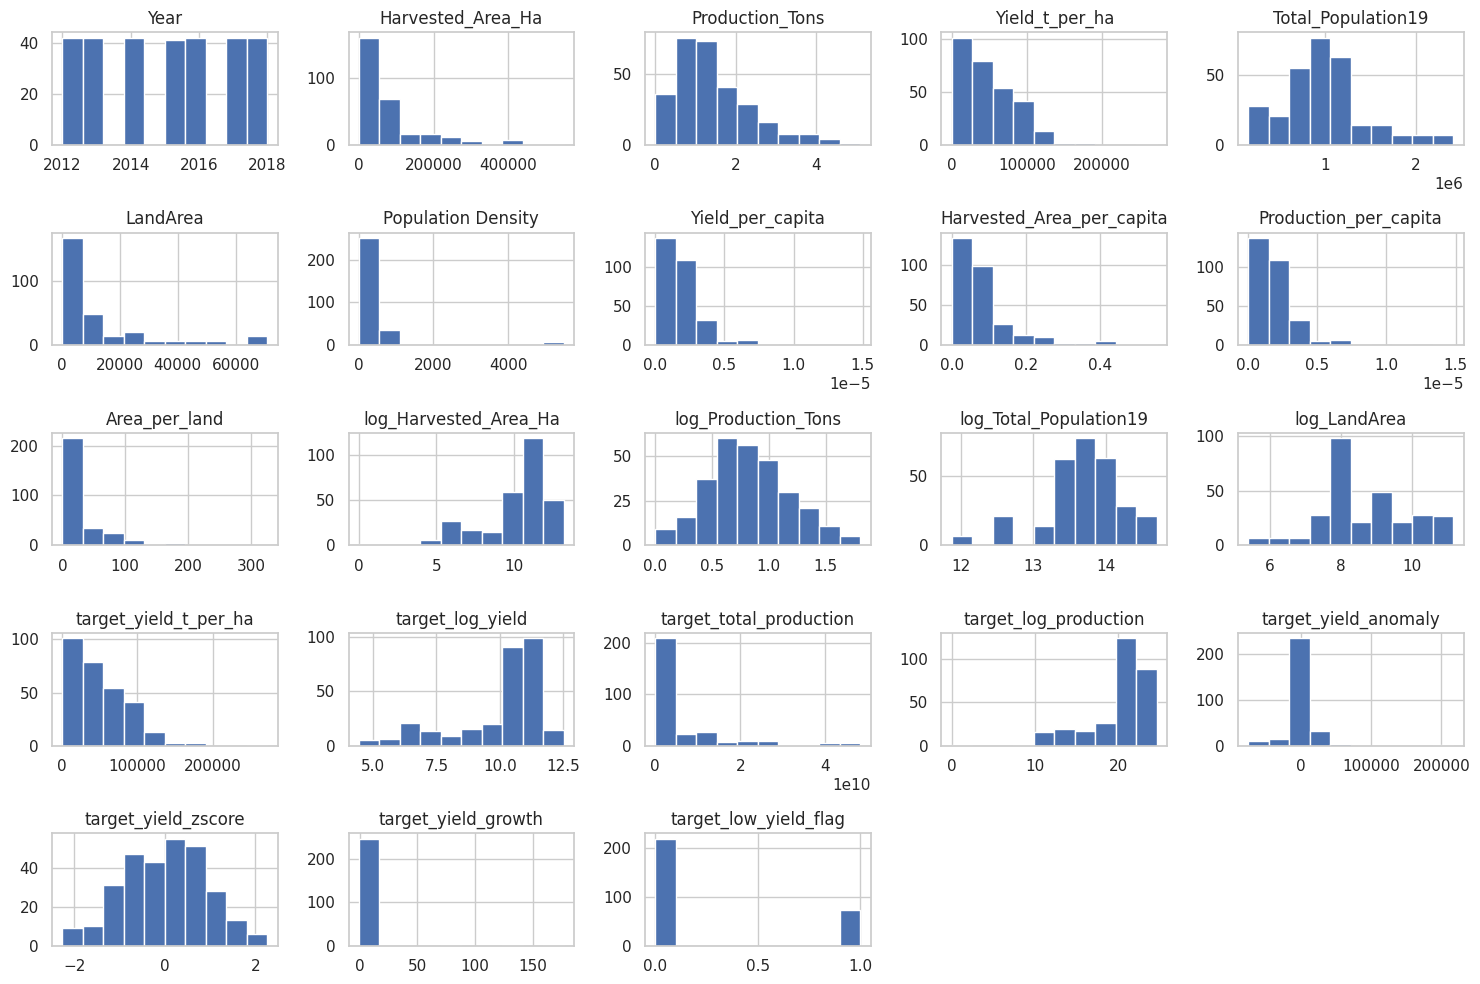

In [57]:
# Visualization of the distributions of numerical features
df_final.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

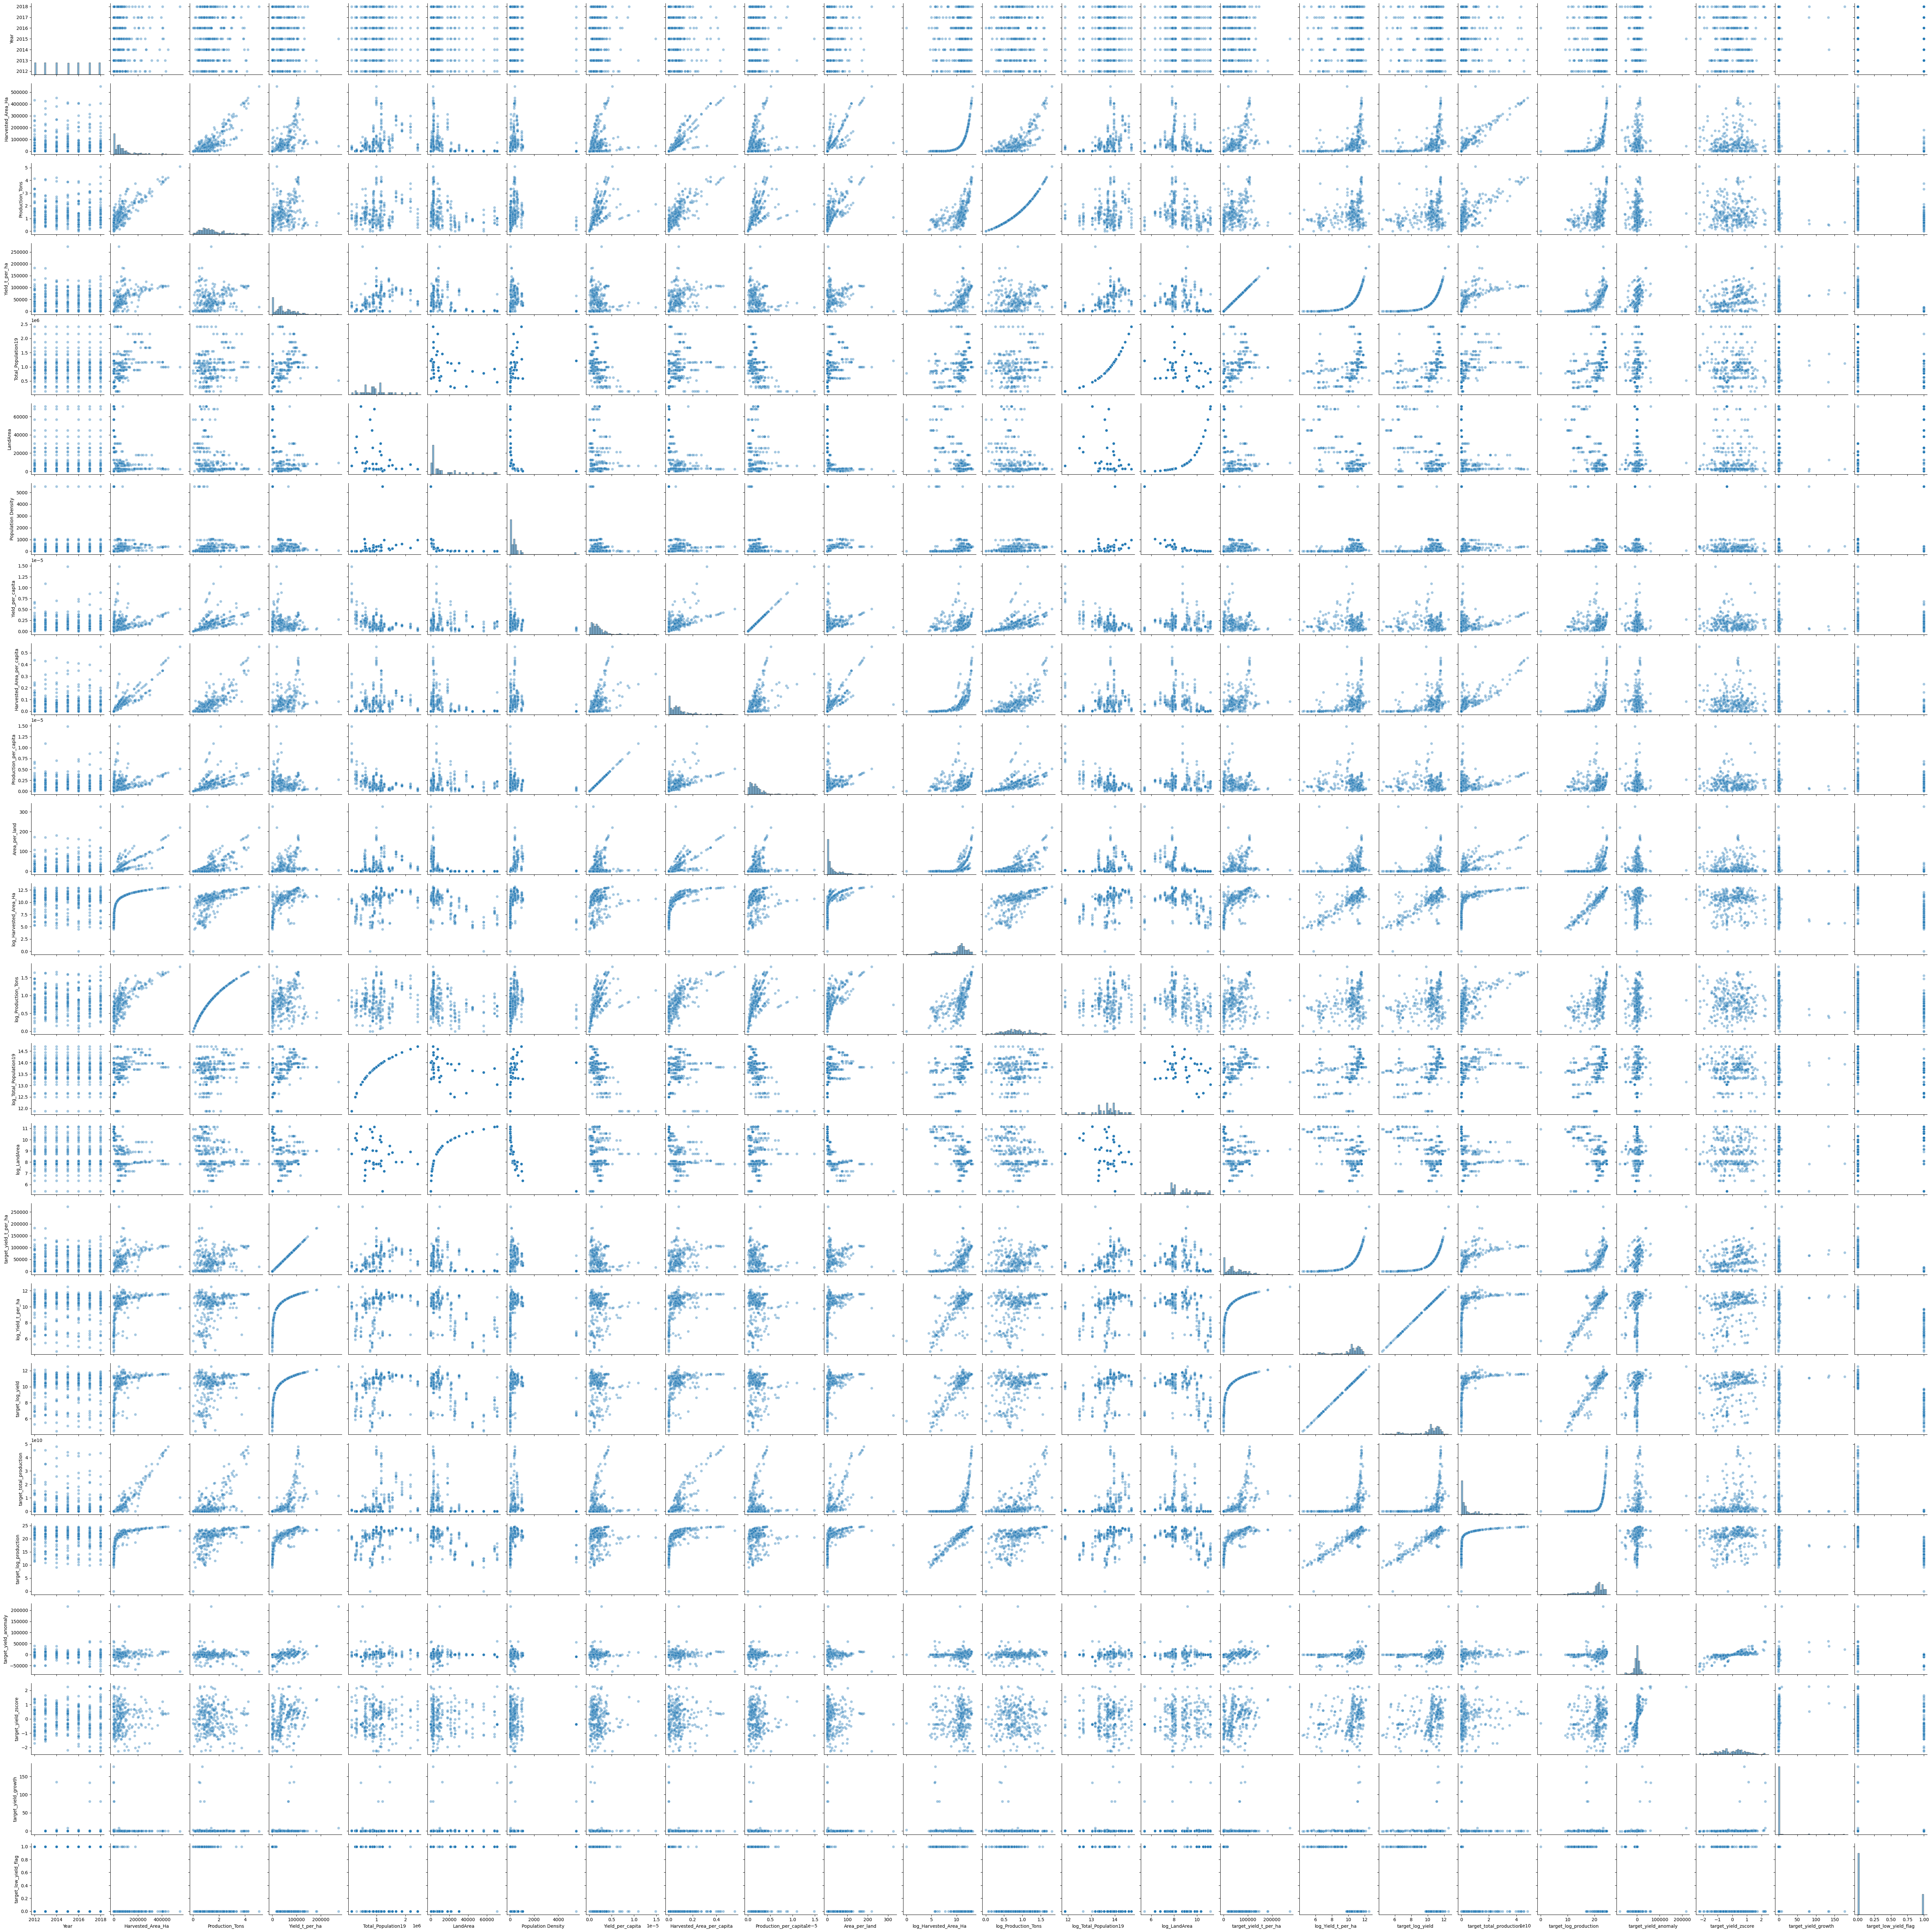

In [ ]:
sns.pairplot(df_final,
             kind='scatter',
             plot_kws={'alpha':0.4},
             diag_kws={'alpha':0.55, 'bins':40})

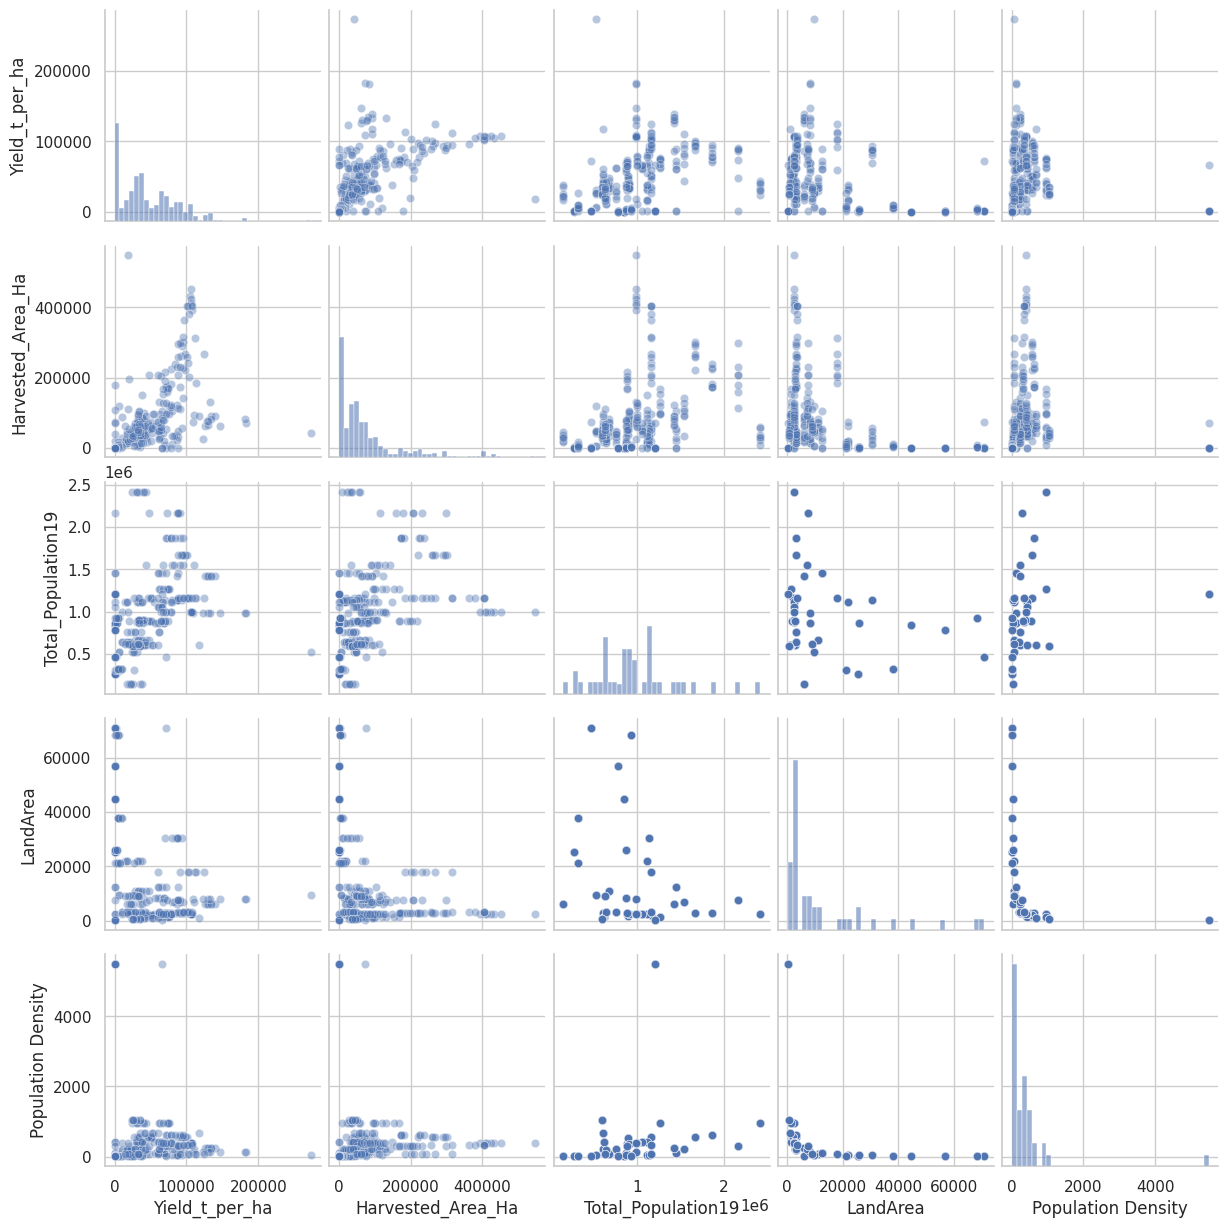

In [58]:

columns_to_plot = ['Yield_t_per_ha', 'Harvested_Area_Ha', 'Total_Population19', 'LandArea', 'Population Density']

sns.pairplot(df_final[columns_to_plot],
             kind='scatter',
             plot_kws={'alpha':0.4},
             diag_kws={'alpha':0.55, 'bins':40})
plt.show()

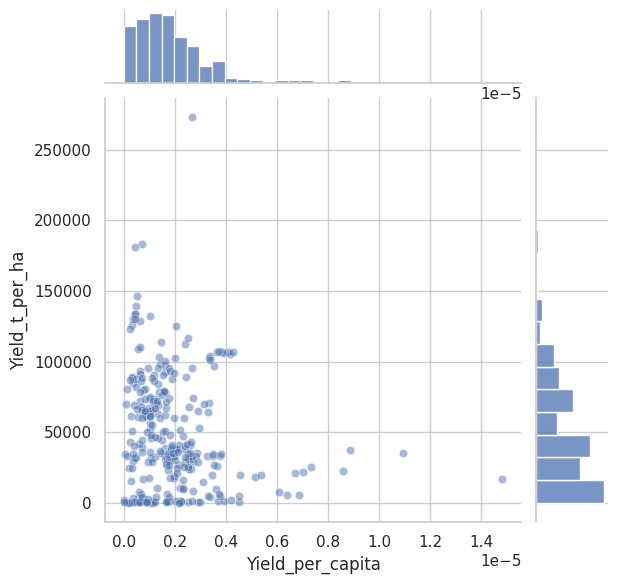

In [59]:
sns.jointplot(x='Yield_per_capita', y='Yield_t_per_ha', data=df_final, alpha=0.5)

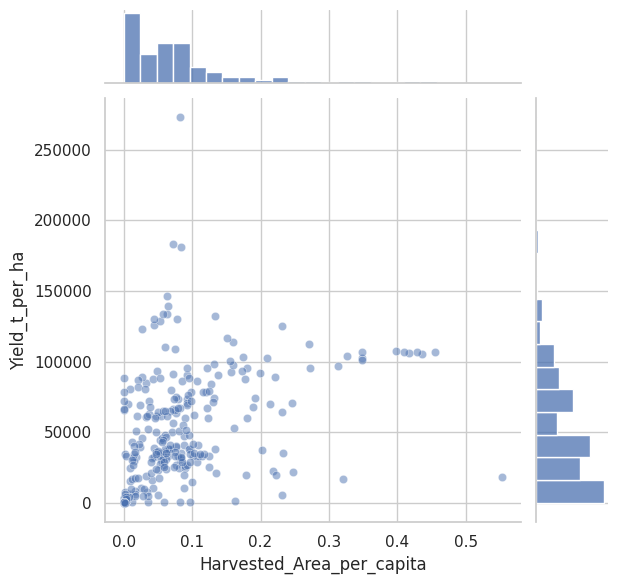

In [60]:
# Scatter plot: Yield vs Harvested Area per capita
sns.jointplot(x='Harvested_Area_per_capita', y='Yield_t_per_ha', data=df_final, alpha=0.5)

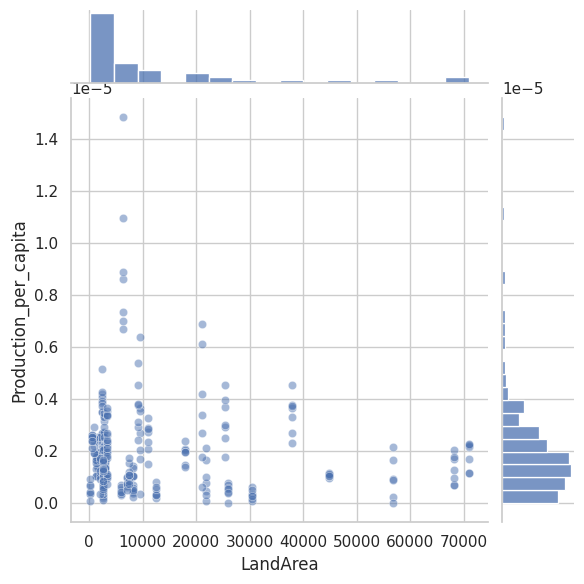

In [61]:
sns.jointplot(x='LandArea', y='Production_per_capita', data=df_final, alpha=0.5)

## Correlation Matrix  

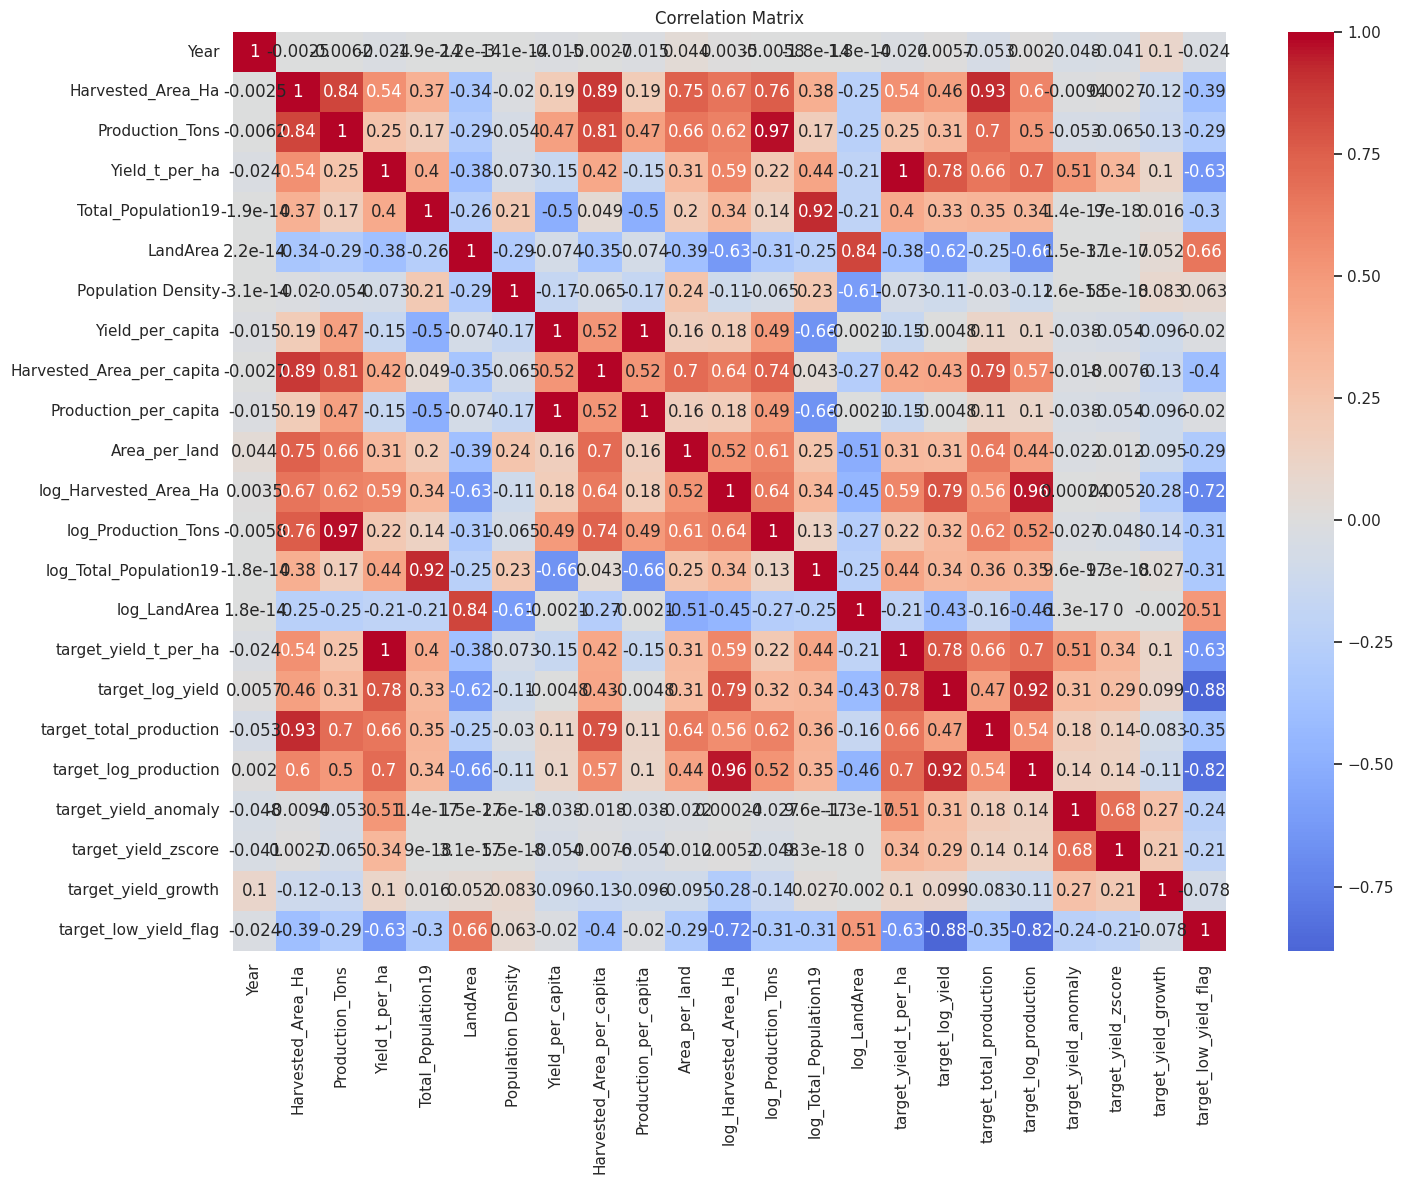

In [62]:
    # Correlation matrix
    numeric_cols = df_final.select_dtypes(include=[np.number]).columns
    corr_matrix = df_final[numeric_cols].corr()

    plt.figure(figsize=(15, 12))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()

To understand how different features relate to each other and to the target variable (Yield per hectare),  
we compute a **correlation matrix**.  

- Positive correlation → as one variable increases, the other also increases.  
- Negative correlation → as one variable increases, the other decreases.  
- Values close to **+1** or **-1** indicate strong relationships.  
- Values near **0** indicate weak or no correlation.  

This analysis helps identify which features are most informative for predicting yield.

### Key Findings from Our Data
1. Strong Multicollinearity: We observe a very strong positive correlation (approximately 0.94) between Harvested_Area_Ha and Production_Tons. This is known as multicollinearity
2. Moderate Negative Correlation with Yield: There is a notable moderate negative correlation (around -0.52) between our target variable, Yield_t_per_ha, and Production_Tons. This suggest that increases in total production are more strongly linked to increases in the harvested area rather than improvements in yield per hectare.
3. Positive Relationships with Yield: Our target variable, Yield_t_per_ha, shows positive correlations with other features, such as Population Density and our newly engineered features like Yield_per_capita and Area_per_land.

# 5. Splitting the data


To evaluate model performance reliably, we split the dataset into **training** and **testing** subsets:  

- **Training set (70%)** → used to fit the model and learn relationships between features and the target.  
- **Testing set (30%)** → kept aside and only used to evaluate the model’s performance on unseen data.  

This prevents overfitting, where the model memorizes the training data but performs poorly on new data.  

We use `random_state=42` to ensure reproducibility — the split will be the same every time the notebook is run.  


In [63]:
from sklearn.model_selection import train_test_split

In [69]:

X = df_final[feature_cols]
y = df_final[target_choice]

In [70]:
X.head()
y.head()

0    10.279112
1    10.461988
2    10.695575
3    10.409220
4    10.413583
Name: log_Yield_t_per_ha, dtype: float64

In [71]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


In [72]:
# Display the shapes of the training and testing sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (205, 5)
Shape of X_test: (88, 5)
Shape of y_train: (205,)
Shape of y_test: (88,)


# 6. Training the Model with multivariable regression using Scikit Learn





We use a **Linear Regression model** from Scikit-Learn to predict maize yield per hectare.  

- The model fits a linear equation of the form:
$$
  [
  y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_n X_n
  ]
$$
  where \( y \) is the target (yield), and \( X_1, X_2, ..., X_n \) are the feature variables.  

- **Coefficients (`coef_`)** → show how much each feature contributes to the prediction, holding other features constant.  
  - Positive coefficient → feature increases yield.  
  - Negative coefficient → feature decreases yield.  

- **R² score (`score`)** → measures how well the model explains the variance in the data (1.0 = perfect fit, 0 = no explanatory power).  

After training, we examine the coefficients to interpret which factors most influence yield.  


In [73]:
from sklearn.linear_model import LinearRegression

In [74]:
lm = LinearRegression()

In [75]:
# Train the model
lm.fit(X_train, y_train)

LinearRegression()

In [76]:
# the coefficients
lm.coef_

array([ 2.11481449e-08,  8.37007522e-07, -5.79039043e-05, -5.52043594e-04,
        3.35779848e+00])

In [77]:
# r squared
lm.score(X, y)

0.5541034012307854

In [78]:
# The coefficients in a dataframe
cdf = pd.DataFrame(lm.coef_,X.columns,columns=['Coef'])
print(cdf)

                                   Coef
Harvested_Area_Ha          2.114814e-08
Total_Population19         8.370075e-07
LandArea                  -5.790390e-05
Population Density        -5.520436e-04
Harvested_Area_per_capita  3.357798e+00


# 7. Training the model with multivariable regression using OLS



We also train a **Linear Regression model using Ordinary Least Squares (OLS)** from `statsmodels`.  

Unlike Scikit-Learn’s `LinearRegression`, OLS provides detailed statistical diagnostics:  

- **Coefficients** → estimated effect of each feature on the target.  
- **P-values** → indicate whether a feature is statistically significant (commonly, p < 0.05 means significant).  
- **R² and Adjusted R²** → measure explanatory power of the model.  
- **F-statistic** → tests whether the overall regression model is statistically significant.  
- **Confidence Intervals** → show the plausible range for each coefficient.  

This richer output helps assess not just model fit, but also the reliability of each predictor.  


In [79]:
import statsmodels.api as sm

X = sm.add_constant(X_train)
model = sm.OLS(y_train, X)
model_fit = model.fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:     log_Yield_t_per_ha   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     48.66
Date:                Mon, 22 Sep 2025   Prob (F-statistic):           9.69e-33
Time:                        04:01:52   Log-Likelihood:                -321.42
No. Observations:                 205   AIC:                             654.8
Df Residuals:                     199   BIC:                             674.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

# Predicting Test Data

In [80]:
# Train the model and save it to a file
lm.fit(X_train, y_train)
joblib.dump(lm, 'maize_yield_predictor.pkl')
print("Model trained and saved successfully.")

Model trained and saved successfully.


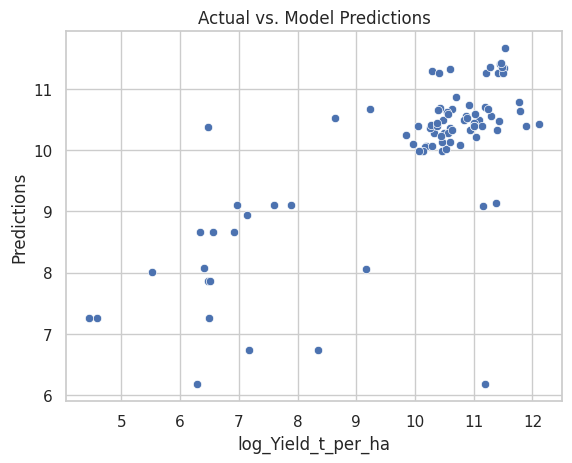

In [81]:
# Make predictions on the test data
y_pred = lm.predict(X_test)

# Scatter plot of actual values of y vs predicted values.
sns.scatterplot(x=y_test, y=y_pred)
plt.ylabel('Predictions')
plt.title('Actual vs. Model Predictions')
plt.show()

# Evaluation of the model

In [82]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [83]:
print('Mean Absolute Error:',mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:',mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:',math.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.8095035527742741
Mean Squared Error: 1.4851469896478455
Root Mean Squared Error: 1.2186660697860778


# Residuals

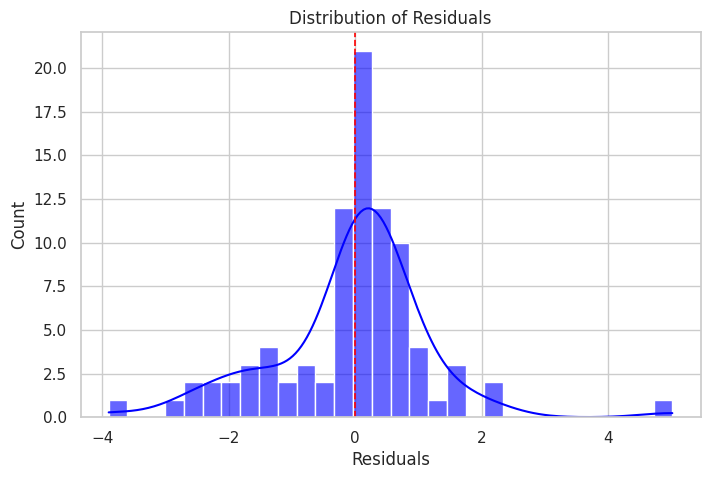

In [88]:
# Compute residuals
residuals = y_test - y_pred

# Plot histogram with KDE
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=30, kde=True, color="blue", alpha=0.6)
plt.axvline(0, color="red", linestyle="--", linewidth=1.2)
plt.xlabel("Residuals")
plt.title("Distribution of Residuals")
plt.show()


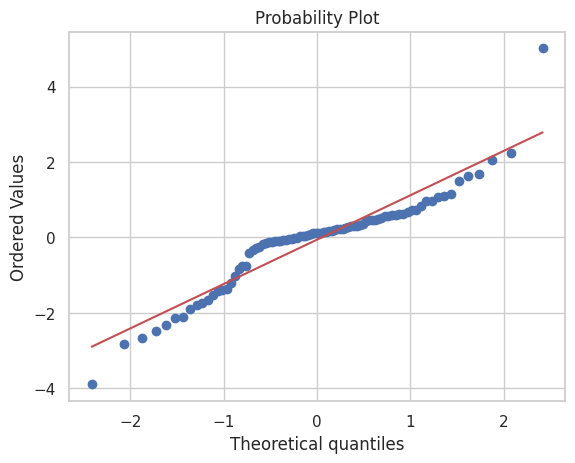

In [86]:
import pylab
import scipy.stats as stats

stats.probplot(residuals, dist="norm", plot=pylab)
pylab.show()

# 8. Conclusion
Regression modeling was employed to Predict maize yield per hectare and investigated agricultural productivity drivers. Preparation of data and feature engineering enabled us to develop target variables and indicators such as growth rates and yield anomalies. We trained Scikit-Learn's Linear Regression and Statsmodels OLS models, and measures of model fit (MAE, MSE, RMSE) reflected good accuracy in prediction. The study highlighted dominant features in yield variation and points out areas of improvement. Future research can delve into sophisticated machine learning models, regularization in cases of multicollinearity, and inclusion of outside data such as weather and soil information. Generally, the study demonstrates regression models can provide useful information in terms of agricultural yield prediction and provide a foundation upon which better forecasting schemes can be developed.